## Pythonデータ分析入門第2回

In [41]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

今回は、婚姻状況、学歴、収入などの顧客情報を含むデータセットを扱います。企業がどのような顧客を扱っているかを把握することは、エンドユーザーにより良いサービスを提供するのに役立ちます。したがって、顧客分析とセグメンテーションは、ビジネスにおいて重要な役割を果たします。  
  
**データセットについて**  
今回について使用するデータセットは[Kaggle](https://www.kaggle.com/code/karnikakapoor/customer-segmentation-clustering/data)で公開されているものです。行の総数は2240であるのに対し、属性(または列)の総数は29です。前述のように、各属性は、婚姻状況、収入、顧客IDなど、顧客の分類に重要な人の特徴に対応します。



In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/My Drive/learning_data_analysis/vol2/"

In [81]:
!ls

'data_analysis_with_python_vol2 (1).ipynb'   marketing_campaign.csv
 data_analysis_with_python_vol2.ipynb


In [46]:
# Pandasを使用してファイルを読み込むことができます
data = pd.read_csv('marketing_campaign.csv', sep="\t")

コマンドを使って最初の5行を表示します。


In [47]:
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [48]:
len(data)

2240

前述の通り、合計2240行のデータ要素があります。欠損値は数学演算の際に異常な振る舞いをする可能性があるため、欠損値を排除しておきましょう。

In [49]:
data = data.dropna()

In [50]:
len(data)

2216

このデータセットには、24個の欠損インスタンスがありました。データセットの Date 属性も DateTime 形式に変換しておきましょう。この属性は、後で顧客がアクティブであった時間を計算するために使用されます。

In [51]:
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"])

<ipython-input-51-e229d5a7a057>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"])


In [52]:
dates = []
for i in data["Dt_Customer"]:
  i = i.date()
  dates.append(i)

新しい属性である <code>Customer_dur</code> を作成し、ある顧客がその会社に関連している期間を計算します。簡単のために、直近の顧客の日付を抽出し、それを使って他の顧客の期間を計算することにします。

In [53]:
days = []
d1 = max(dates) 
for i in dates:
  delta = d1 - i
  days.append(delta)
data["Customer_dur"] = days
data["Customer_dur"] = pd.to_numeric(data["Customer_dur"], errors="coerce")

<ipython-input-53-950fa756e4c9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Customer_dur"] = days
<ipython-input-53-950fa756e4c9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Customer_dur"] = pd.to_numeric(data["Customer_dur"], errors="coerce")


In [54]:
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Customer_dur
0,5524,1957,Graduation,Single,58138.0,0,0,2012-04-09,58,635,...,0,0,0,0,0,0,3,11,1,83894400000000000
1,2174,1954,Graduation,Single,46344.0,1,1,2014-08-03,38,11,...,0,0,0,0,0,0,3,11,0,10800000000000000
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,0,0,0,0,0,0,3,11,0,40780800000000000
3,6182,1984,Graduation,Together,26646.0,1,0,2014-10-02,26,11,...,0,0,0,0,0,0,3,11,0,5616000000000000
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,0,0,0,0,0,0,3,11,0,27734400000000000


では、次の属性である <code>Marital Status</code> を見てみましょう。<code>head</code>コマンドで見ると、2つ以上のカテゴリがあるように見えます。

In [55]:
data["Marital_Status"].value_counts()

Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64

この属性には、さらに8つのカテゴリーがあります。これらを分析しやすいように、２つのグループ化することにします。ここでは、<code>Partner</code>または<code>Alone</code>の2つの値を持つバイナリ属性、<code>Living_With</code>を作成します。

In [56]:
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner",
                                                    "Together":"Partner",
                                                    "Absurd":"Alone",
                                                    "Widow":"Alone",
                                                    "YOLO":"Alone",
                                                    "Divorced":"Alone",
                                                    "Single":"Alone",})

<ipython-input-56-7cb5956a8b04>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner",


補助的な情報ができたので、<code>Marital_Status</code>は不要な属性値となるため一旦削除します。また、プロモーションやキャンペーン情報を含むカラムも、顧客セグメンテーションには関係がないので、削除します。

In [57]:
cols_del = ['Marital_Status', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']

In [58]:
data = data.drop(cols_del, axis=1)

In [59]:
data.head()

,ID,Year_Birth,Education,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Z_CostContact,Z_Revenue,Customer_dur,Living_With
0,5524,1957,Graduation,58138.0,0,0,2012-04-09,58,635,88,...,88,3,8,10,4,7,3,11,83894400000000000,Alone
1,2174,1954,Graduation,46344.0,1,1,2014-08-03,38,11,1,...,6,2,1,1,2,5,3,11,10800000000000000,Alone
2,4141,1965,Graduation,71613.0,0,0,2013-08-21,26,426,49,...,42,1,8,2,10,4,3,11,40780800000000000,Partner
3,6182,1984,Graduation,26646.0,1,0,2014-10-02,26,11,4,...,5,2,2,0,4,6,3,11,5616000000000000,Partner
4,5324,1981,PhD,58293.0,1,0,2014-01-19,94,173,43,...,15,5,5,3,6,5,3,11,27734400000000000,Partner


では、<code>Education</code>属性がいくつのカテゴリーを持つか見てみましょう。

In [60]:
data["Education"].value_counts()

Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64

上記と同じステップを <code>Education</code> 属性でも繰り返します。この場合、カテゴリは <code>Undergraduate, Graduate, Postgraduate</code> となります。

In [61]:
data["Education"]=data["Education"].replace({"Basic":"Undergraduate",
                                             "2n Cycle":"Undergraduate",
                                             "Graduation":"Graduate",
                                             "Master":"Postgraduate",
                                             "PhD":"Postgraduate"})

後で計算しやすいように、元々の属性値から派生した、新しい属性をいくつか作成します。作成する属性は以下の通りです。
<ol>
<li><code>Age</code>: <code>Year_of_Birth</code> から導き出すことができる</li>
<li><code>Spent</code>: ワイン、果物、魚など、食べられるものの総量</li>
<li><code>Children</code>: <code>Kidhome</code> と <code>Teenhome</code> の合計</li>
<li><code>Family_Size</code>: <code>Children</code> 属性と一緒に <code>Living_With</code> 属性も使用することになります</li>
<li><code>Is_Parent</code>: <code>Children</code> 属性から派生した、0 か 1 の値を持つバイナリ属性</li>
</ol>

In [62]:
data["Age"] = 2021-data["Year_Birth"]
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]
data["Children"]=data["Kidhome"]+data["Teenhome"]
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

先ほどと同様に、冗長な、不要な属性値は削除します。

In [63]:
to_drop = ["Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

In [64]:
data.head()

,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_dur,Living_With,Age,Spent,Children,Family_Size,Is_Parent
0,Graduate,58138.0,0,0,58,635,88,546,172,88,...,10,4,7,83894400000000000,Alone,64,1617,0,1,0
1,Graduate,46344.0,1,1,38,11,1,6,2,1,...,1,2,5,10800000000000000,Alone,67,27,2,3,1
2,Graduate,71613.0,0,0,26,426,49,127,111,21,...,2,10,4,40780800000000000,Partner,56,776,0,2,0
3,Graduate,26646.0,1,0,26,11,4,20,10,3,...,0,4,6,5616000000000000,Partner,37,53,1,3,1
4,Postgraduate,58293.0,1,0,94,173,43,118,46,27,...,3,6,5,27734400000000000,Partner,40,422,1,3,1


In [65]:
data.describe()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_dur,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,4.085289,2.671029,5.800993,5.319043,4.423735e+16,52.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,2.740951,2.926734,3.250785,2.425359,2.008532e+16,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,25.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,2.000000,0.000000,3.000000,3.000000,2.937600e+16,44.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,4.000000,2.000000,5.000000,6.000000,4.432320e+16,51.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,6.000000,4.000000,8.000000,7.000000,5.927040e+16,62.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,27.000000,28.000000,13.000000,20.000000,9.184320e+16,128.000000,2525.000000,3.000000,5.000000,1.000000


### 相関関係を可視化する
<code>Is_Parent</code>を主な分類属性としながら、新しく作成したこれらの特徴量をペアごとにプロットしてみます。

<Figure size 432x288 with 0 Axes>

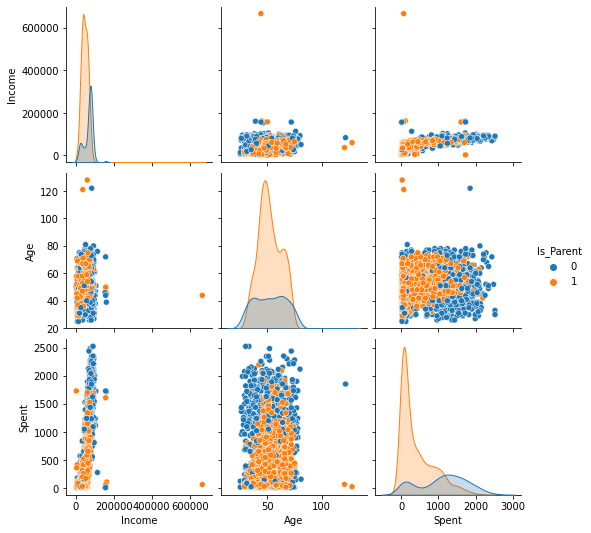

In [66]:
To_Plot = [ "Income", "Age", "Spent", "Is_Parent"]
plt.figure()
sns.pairplot(data[To_Plot], hue= "Is_Parent") 
plt.show()

いくつかの異常値(外れ値)があることがわかります。
<code>Age&gt;100</code> は極めて低い(特に150歳以上に見えるものが３点ほどある)。  
これは、いくつかのデータ要素が古い可能性を示唆しています。また、データの大部分は閾値80以下に集中しています。そのため、この閾値を超える少数の要素を除外することにします。

<code>Income&gt;600000</code> の要素は1つだけです。
これも先に削除しておきましょう。

In [67]:
data = data[(data["Age"]<90)]
data = data[(data["Income"]<600000)]

In [68]:
len(data)

2212

### データのエンコード
カテゴリ変数は、文字列の値を直接数学的な演算に使うことができないため、機械学習タスクの前にエンコードする必要があります。データセットに含まれるカテゴリ属性を出力してみましょう。

In [69]:
s = (data.dtypes == 'object')
object_cols = list(s[s].index)
object_cols

['Education', 'Living_With']

対象の値を0からn-1までのクラスにエンコードするscikit-learnのLabel Encoderを使用します。この例では、<code>Education</code>は3つのカテゴリを持つので、値はそれぞれ <code>0,1,2</code> で示されます。同様に、<code>Living_With</code> はバイナリ属性なので、値は <code>0 または 1</code> の形式をとることになります。

In [70]:
LE=LabelEncoder()
for i in object_cols:
  data[i]=data[[i]].apply(LE.fit_transform)

In [71]:
data.head()

,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_dur,Living_With,Age,Spent,Children,Family_Size,Is_Parent
0,0,58138.0,0,0,58,635,88,546,172,88,...,10,4,7,83894400000000000,0,64,1617,0,1,0
1,0,46344.0,1,1,38,11,1,6,2,1,...,1,2,5,10800000000000000,0,67,27,2,3,1
2,0,71613.0,0,0,26,426,49,127,111,21,...,2,10,4,40780800000000000,1,56,776,0,2,0
3,0,26646.0,1,0,26,11,4,20,10,3,...,0,4,6,5616000000000000,1,37,53,1,3,1
4,1,58293.0,1,0,94,173,43,118,46,27,...,3,6,5,27734400000000000,1,40,422,1,3,1


### データのスケーリング（標準化）
これらの数値はスケールが異なることにも注意が必要です。これは、ある属性が他の属性よりも大きく重要視されるような偏ったモデルになる可能性があります。したがって、同じようなスケールでマッピングすることが重要です。  

標準化(`sklearn.preprocessing.StandardScaler`)の、計算方法の詳細は、<a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html">こちら</a>を参照してください。

In [72]:
scaler = StandardScaler()
scaler.fit(data)
scaled_data = pd.DataFrame(scaler.transform(data),columns= data.columns)

In [73]:
scaled_data.head()

,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_dur,Living_With,Age,Spent,Children,Family_Size,Is_Parent
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,2.503607,-0.555814,0.692181,1.973583,-1.349603,1.018352,1.676245,-1.264598,-1.758359,-1.581139
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-0.571340,-1.171160,-0.132545,-1.665144,-1.349603,1.274785,-0.963297,1.404572,0.449070,0.632456
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,-0.229679,1.290224,-0.544908,-0.172664,0.740959,0.334530,0.280110,-1.264598,-0.654644,-1.581139
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.913000,-0.555814,0.279818,-1.923210,0.740959,-1.289547,-0.920135,0.069987,0.449070,0.632456
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.111982,0.059532,-0.132545,-0.822130,0.740959,-1.033114,-0.307562,0.069987,0.449070,0.632456


### 次元削減
標準化されたデータができましたが、列の総数がまだ多いので、これを処理する必要があります。列の数が多くなると次元が高くなり、作業が困難になります。簡単のために、いくつかの列はすでに冗長であるため、列の総数を3つに減らすことにします。  

主成分分析（PCA）は、情報の損失を最小限に抑えつつ次元削減を行うことができるため、次元削減によく使われる手法の1つです。

In [74]:
pca = PCA(n_components=3)
pca.fit(scaled_data)
pca_data = pd.DataFrame(pca.transform(scaled_data), columns=(["c1","c2", "c3"]))

In [75]:
pca_data.describe().T

,count,mean,std,min,25%,50%,75%,max
c1,2212.0,-1.670354e-16,2.878377,-5.969394,-2.538494,-0.780421,2.383290,7.444305
c2,2212.0,6.424437e-18,1.706839,-4.312169,-1.328322,-0.158158,1.242287,6.142691
c3,2212.0,5.460771e-17,1.221956,-3.530092,-0.828537,-0.021762,0.799767,6.612448


### クラスタリング
データのクレンジングと3次元化が完了したので、データをクラスタに分割します。ここでは、scikit-learnライブラリのAgglomerative Clusteringを使用します。凝集型クラスタリングは、連結距離を用いた再帰的なクラスタリング手法です。詳細は<a href="https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html">こちら</a>を参照してください。  

現実のモデルでは、[Elbow法](https://hkawabata.github.io/technical-note/note/ML/Evaluation/elbow-method.html)のように、データのサンプルに対して理想的なクラスター数を予想するアプローチがあります。

In [76]:
ac = AgglomerativeClustering(n_clusters=4)
customer_ac = ac.fit_predict(pca_data)

このデータを元のdataframeに追加してみましょう。

In [77]:
pca_data["Clusters"] = customer_ac
data["Clusters"]= customer_ac

### クラスタを可視化する
今度は、これらクラスタをプロットして、3Dで可視化してみましょう。

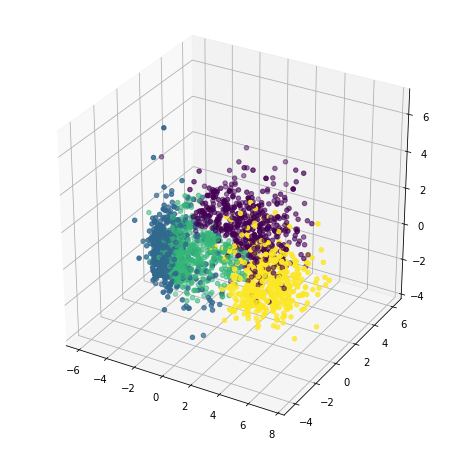

In [78]:
x =pca_data["c1"]
y =pca_data["c2"]
z =pca_data["c3"]

fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection='3d')
ax.scatter(x, y, z, s=20, c=pca_data["Clusters"])
plt.show()

事前に作成した他の属性と<code>Spent</code>属性をプロットしてみましょう。これにより、最終的な結果が各属性によってどのように影響されるか、またどのような顧客が各クラスタに属しているかを知ることができます。

<Figure size 432x288 with 0 Axes>

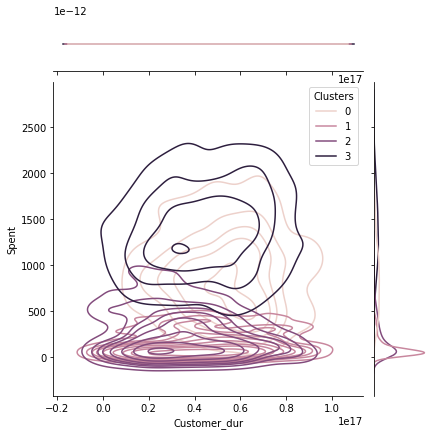

<Figure size 432x288 with 0 Axes>

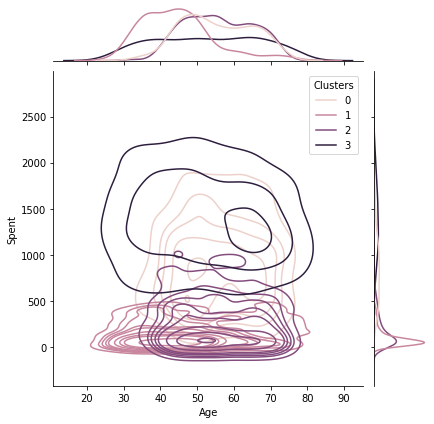

<Figure size 432x288 with 0 Axes>

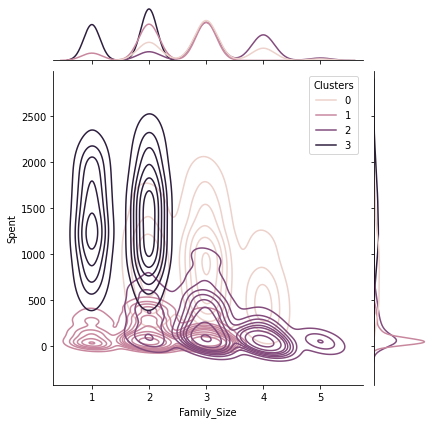

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


<Figure size 432x288 with 0 Axes>

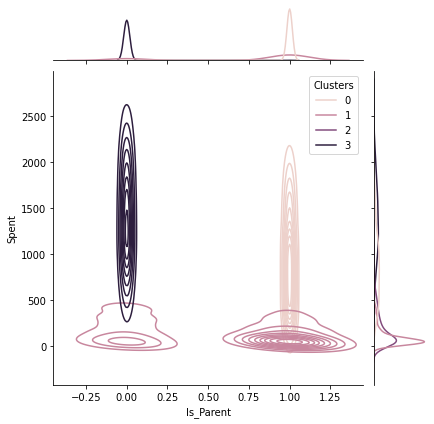

<Figure size 432x288 with 0 Axes>

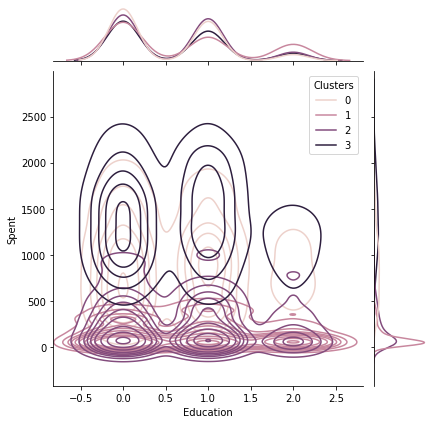

<Figure size 432x288 with 0 Axes>

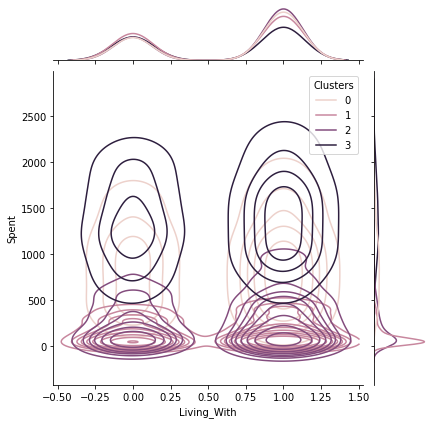

In [79]:
columns = [ "Customer_dur", "Age", "Family_Size", "Is_Parent", "Education","Living_With"]
h = data["Clusters"]
for col in columns:
  plt.figure()
  sns.jointplot(x=data[col], y=data["Spent"], hue=h, kind="kde")
  plt.show()

### 考察
上記の可視化されたものから、いくつかの重要な知見を得ることができます。
<ol>
<li><strong>クラスター0</strong>: 親がいる、40-70歳代、家族規模2-4人。</li>
<li><strong>クラスター1</strong>: 親ではない、30～80歳代、家族数1～2人。</li>
<li><strong>クラスター2</strong>: お客様の大半が親であり、20～80代のすべての年齢層で、家族の人数は1～3人。</li>
<li><strong>クラスター3</strong>: 親がほとんどで、年齢層は35～75歳、家族構成は2～5人。</li>
</ol>

<code>Customer_dur</code> 属性はクラスタ全体にまたがっており、1つのクラスタに特化していないため、幅広く広がった形状を得ることができます。

今回は、Kaggleに公開されている顧客プロファイルデータを調査し、それが企業のビジネスにどのような影響を与えるかを見てきました。また、凝集型クラスタリングを使用して顧客をセグメント化しました。最後に、各クラスタに対応するいくつかの重要な特徴を特定しました。